In [1]:
!uv pip install kagglehub

Using Python 3.11.6 environment at: /Users/nyeinchan/Desktop/time-series/.venv
Audited 1 package in 26ms


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import kagglehub

from numba import njit

import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

/Users/nyeinchan/Desktop/time-series/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar

from statsforecast import StatsForecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate

from window_ops.rolling import rolling_mean, rolling_std, rolling_min, rolling_max

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import optuna
from sklearn.metrics import mean_absolute_error

In [4]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

dataset = "COMED_hourly.csv"

df = pd.read_csv(f'{path}/{dataset}')
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  str    
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), str(1)
memory usage: 2.2 MB


In [5]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

df.head(10)

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0
5,2011-01-01 06:00:00,8711.0
6,2011-01-01 07:00:00,8943.0
7,2011-01-01 08:00:00,9222.0
8,2011-01-01 09:00:00,9430.0
9,2011-01-01 10:00:00,9670.0


In [6]:
df['ds'] = pd.to_datetime(df['Datetime'])
df = df.rename(columns={'COMED_MW': 'y'})
df['unique_id'] = 'comed_hourly'
df = df[['unique_id', 'ds', 'y']]

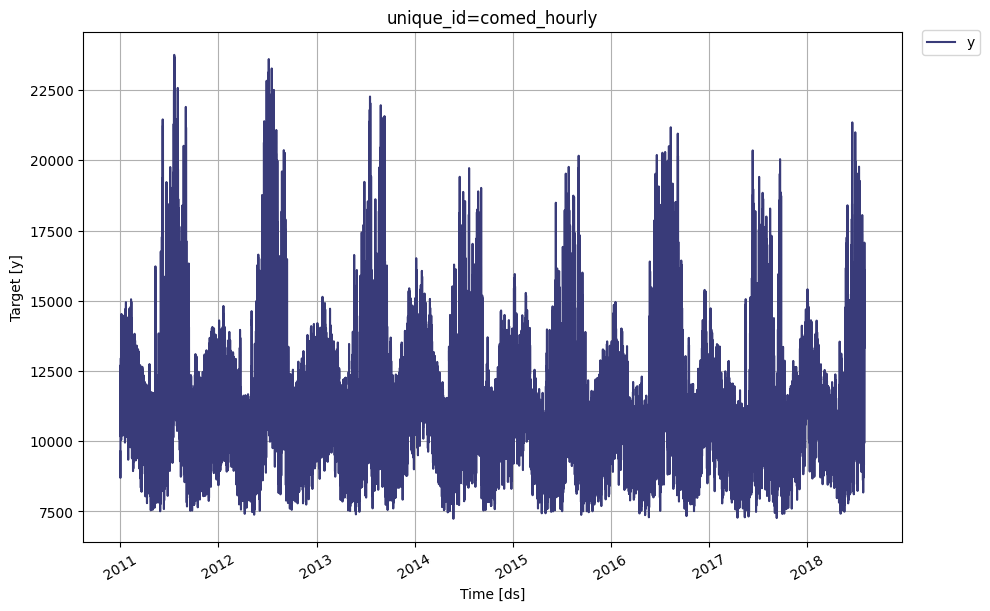

In [7]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f


Handle DST issues just like in stats notebook

In [8]:
df[df['ds'].duplicated(keep=False)].sort_values('ds')

,unique_id,ds,y
33618,comed_hourly,2014-11-02 02:00:00,9184.0
33619,comed_hourly,2014-11-02 02:00:00,8869.0
42354,comed_hourly,2015-11-01 02:00:00,8270.0
42355,comed_hourly,2015-11-01 02:00:00,7923.0
51258,comed_hourly,2016-11-06 02:00:00,8028.0
51259,comed_hourly,2016-11-06 02:00:00,7814.0
59994,comed_hourly,2017-11-05 02:00:00,8198.0
59995,comed_hourly,2017-11-05 02:00:00,7878.0


In [9]:
dst_times = [
    "2014-11-02 02:00:00",
    "2015-11-01 02:00:00",
    "2016-11-06 02:00:00",
    "2017-11-05 02:00:00",
]

for t in dst_times:
    t = pd.Timestamp(t)

    rows = df[df['ds'] == t]

    combined_y = rows['y'].sum() / 2

    # keep the first row
    keep_idx = rows.index[0]
    drop_idx = rows.index[1]

    df.loc[keep_idx, 'y'] = combined_y
    df = df.drop(drop_idx)


full_range = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='h')})

df = full_range.merge(df, on='ds', how='left')
df['unique_id'] = df['unique_id'].ffill()

df['y'] = df['y'].interpolate(method='linear')

### Feature Engineering

Since comparing baseline methods with statistical methods.\
SeasonalNaive_Daily is has the highest accruacy and it means\
Today at 3pm ~= Yesterday at 3pm

`residual_24_hour = y_t - y_t-24`

Also weekly pattern

`residual_168_hour = y_t - y_t-168`

Also pattern deviation weekly

`residual_168_24 = (y_t - y_t-24) - (y_t-168 - y_t-192)`

<br>

List of features that will be added
- Residual features
- Lag features
- Rolling statistics 24, 168
- Calendar Features
- Fourier terms - optional

In [10]:
# residual_24 = y_t - y_t-24
@njit
def residual_24(x):
    n = len(x)
    out = np.empty(n)
    for i in range(n):
        if i < 24:
            out[i] = np.nan
        else:
            out[i] = x[i] - x[i - 24]
    return out

# residual_168 = y_t - y_t-168
@njit
def residual_168(x):
    n = len(x)
    out = np.empty(n)
    for i in range(n):
        if i < 168:
            out[i] = np.nan
        else:
            out[i] = x[i] - x[i - 168]
    return out

# residual_168_24 = (y_t - y_t-24) - (y_t-168 - y_t-192)
@njit
def residual_168_24(x):
    n = len(x)
    out = np.empty(n)
    for i in range(n):
        if i < 192:
            out[i] = np.nan
        else:
            d_now  = x[i]     - x[i - 24]
            d_week = x[i-168] - x[i - 192]
            out[i] = d_now - d_week
    return out

In [11]:
# calendar features
df['hour'] = df['ds'].dt.hour
df['dayofweek'] = df['ds'].dt.day_of_week
df['month'] = df['ds'].dt.month

cal = USFederalHolidayCalendar()
us_holidays = cal.holidays(start=df['ds'].min(), end=df['ds'].max())
ds_norm = df['ds'].dt.normalize()

df['is_holiday'] = ds_norm.isin(us_holidays).astype(int)

In [12]:
# fourier harmonics for annual cycle
day_of_year = df['ds'].dt.dayofyear
for k in range(1, 4):
    # k=3 cycles per year
    df[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * day_of_year / 365.25)
    df[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * day_of_year / 365.25)

In [13]:
# drop nan-values from first shifts
df_clean = df.dropna().reset_index(drop=True)

test_size = 24 * 14
train_ml = df_clean.iloc[:-test_size]
test_ml  = df_clean.iloc[-test_size:]

In [ ]:
exogeneous_features = [
    'hour', 'dayofweek', 'month',
    'is_holiday',
    'sin_annual_1', 'cos_annual_1',
    'sin_annual_2', 'cos_annual_2',
    'sin_annual_3', 'cos_annual_3',
]

mlf = MLForecast(
    models={
        'xgboost': XGBRegressor(n_estimators=500, learning_rate=0.01, verbosity=0),
        'catboost': CatBoostRegressor(iterations=500, learning_rate=0.01, verbose=0, loss_function='RMSE'),
        # fit with linear tree for lgbm for extrapolation
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0, linear_tree=True),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        # mlforecast will update them recursively at prediction steps
        1: [residual_24, residual_168, residual_168_24],
        24: [(rolling_mean, 24), (rolling_std, 24), (rolling_max, 24), (rolling_min, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168), (rolling_max, 168), (rolling_min, 168)],
    },
)

mlf.fit(train_ml[['unique_id', 'ds', 'y'] + exogeneous_features], static_features=[])

# predict
future_exog = test_ml[['unique_id', 'ds'] + exogeneous_features]
preds = mlf.predict(h=336, X_df=future_exog)

preds

,unique_id,ds,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12567.421875,12676.695998,12584.840144
1,comed_hourly,2018-07-20 02:00:00,11629.375000,11864.014138,11673.382477
2,comed_hourly,2018-07-20 03:00:00,11027.214844,11203.966364,10998.587759
3,comed_hourly,2018-07-20 04:00:00,10600.462891,10693.642482,10510.868002
4,comed_hourly,2018-07-20 05:00:00,10390.158203,10496.726012,10218.338725
...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,15019.197266,12504.065746,16368.758444
332,comed_hourly,2018-08-02 21:00:00,14572.433594,12351.197490,15727.798859
333,comed_hourly,2018-08-02 22:00:00,14151.581055,12173.332592,15266.025554
334,comed_hourly,2018-08-02 23:00:00,13767.311523,11854.083006,14751.428480


In [33]:
feature_names = mlf.ts.features_order_

lgbm_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': mlf.models_['lgbm'].feature_importances_
}).sort_values('importance', ascending=False)

lgbm_imp[:10]

,feature,importance
0,hour,2653
10,lag1,1387
11,lag2,689
5,cos_annual_1,466
1,dayofweek,426
16,residual_24_lag1,401
12,lag24,326
17,residual_168_lag1,251
14,lag168,248
20,rolling_std_lag24_window_size24,158


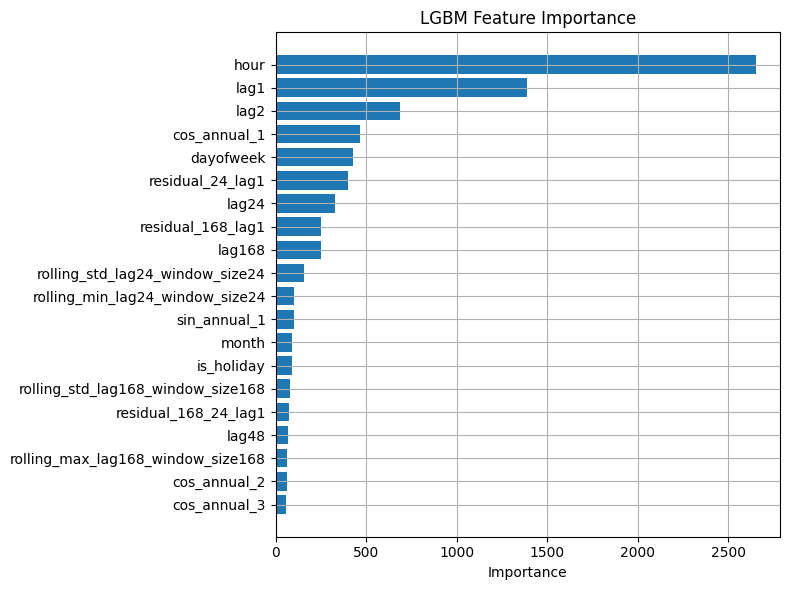

In [34]:
top_k = 20

df_plot = lgbm_imp.head(top_k).sort_values('importance')

plt.figure(figsize=(8, 6))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Importance')
plt.title('LGBM Feature Importance')
plt.tight_layout()
plt.show()

cross-validation

In [35]:
cv_ml = mlf.cross_validation(
    df=train_ml[['unique_id', 'ds', 'y'] + exogeneous_features],
    h=336,
    n_windows=5,
    step_size=336,
    static_features=[]
)

In [36]:
eval_ml = evaluate(
    cv_ml,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

eval_ml

,unique_id,cutoff,metric,xgboost,catboost,lgbm
0,comed_hourly,2018-05-11,mae,509.223158,782.016715,388.117105
1,comed_hourly,2018-05-25,mae,1688.541719,1752.765132,1885.427055
2,comed_hourly,2018-06-08,mae,1884.483172,2127.676034,1543.842783
3,comed_hourly,2018-06-22,mae,2953.406355,2846.600649,1285.463097
4,comed_hourly,2018-07-06,mae,1509.404198,2159.486276,1017.009957
5,comed_hourly,2018-05-11,rmse,703.580856,1015.335216,656.059526
6,comed_hourly,2018-05-25,rmse,2346.056935,2377.213761,2434.372690
7,comed_hourly,2018-06-08,rmse,2890.429672,2929.477759,2258.055794
8,comed_hourly,2018-06-22,rmse,3798.289262,3760.819236,1590.156950
9,comed_hourly,2018-07-06,rmse,1886.397039,2727.830769,1227.704086


In [37]:
eval_ml[eval_ml['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

lgbm        1633.269809
xgboost     2324.950753
catboost    2562.135348
dtype: float64

lgbm        1684.689266
xgboost     2324.950753
catboost    2562.135348
dtype: float64

lgbm        1684.689266
xgboost     2324.950753
catboost    2562.135348
dtype: float64

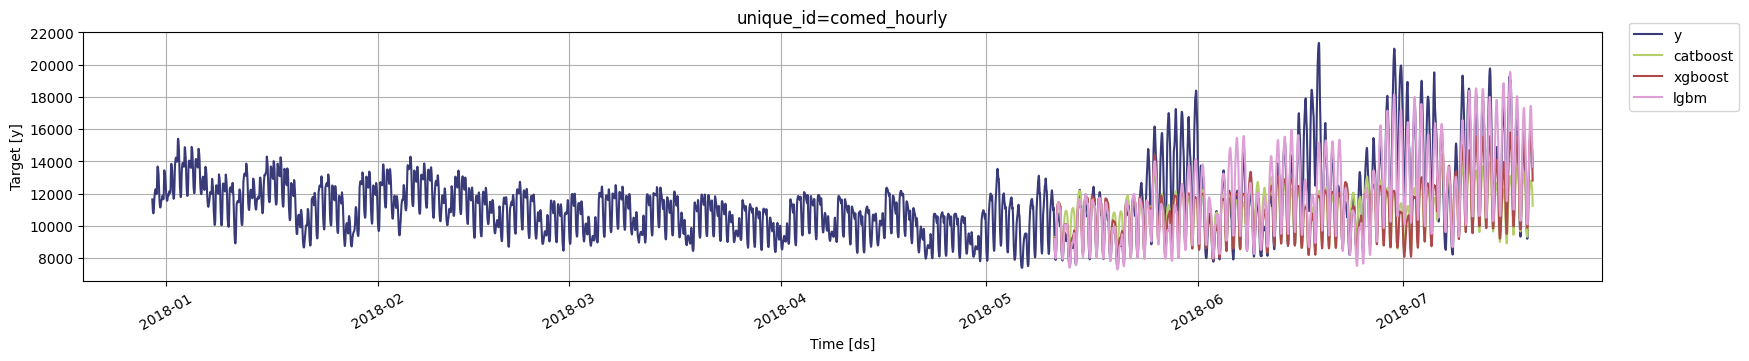

In [38]:
# comparing across 5 folds
StatsForecast.plot(
    train_ml[24*365*7:],
    cv_ml[
        [
            'unique_id', 'ds', 
            'catboost',
            'xgboost',
            'lgbm',
        ]
    ]
)

- shapes are mostly correct but the amplitudes still underpredicts in summer time
- summer spikes are harder to predict | extrapolation is necessary
- adding weather | temperature features will surely improve the model

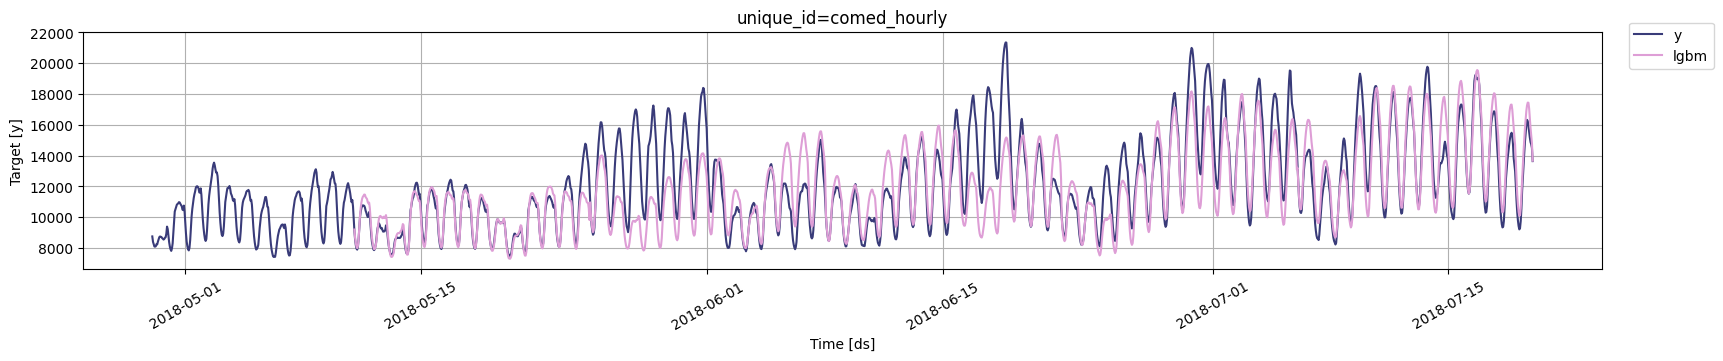

In [39]:
# comparing across 5 folds zoomed
StatsForecast.plot(
    train_ml[(24*365*7)+(24*120):],
    cv_ml[
        [
            'unique_id', 'ds', 
            'lgbm',
        ]
    ]
)

In [ ]:
# optuna.logging.set_verbosity(optuna.logging.INFO)

# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 300, 900),
#         'learning_rate'   : trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
#         'num_leaves'      : trial.suggest_int('num_leaves', 16, 64),
#         'max_depth'       : trial.suggest_int('max_depth', 4, 8),
#         'min_child_samples': trial.suggest_int('min_child_samples', 20, 80),
#         'linear_tree'     : True,   # always keep
#         'verbose'         : -1,
#     }

#     mlf_trial = MLForecast(
#         models={'lgbm': LGBMRegressor(**params)},
#         freq='h',
#         lags=[1, 2, 24, 48, 168, 336],
#         lag_transforms={
#             24:  [(rolling_mean, 24),  (rolling_std, 24),
#                   (rolling_max, 24),   (rolling_min, 24)],
#             168: [(rolling_mean, 168), (rolling_std, 168),
#                   (rolling_max, 168),  (rolling_min, 168)],
#             1:   [residual_24, residual_168, residual_168_24],
#         },
#     )

#     cv_result = mlf_trial.cross_validation(
#         df=train_ml[['unique_id', 'ds', 'y'] + exogeneous_features],
#         h=336,
#         n_windows=3,
#         step_size=336,
#         static_features=[]
#     )

#     score = mean_absolute_error(cv_result['y'], cv_result['lgbm'])
#     return score

# study = optuna.create_study(
#     direction='minimize',
#     sampler=optuna.samplers.TPESampler(seed=555)
# )

# study.optimize(objective, n_trials=15, show_progress_bar=True)

# print("Best MAE:   ", study.best_value)
# print("Best params:", study.best_params)

[I 2026-02-17 00:47:59,705] A new study created in memory with name: no-name-77d129e5-4fba-47dd-b000-0b9c859865fa
Best trial: 0. Best value: 1959.39:   7%|▋         | 1/15 [00:50<11:42, 50.17s/it]

[I 2026-02-17 00:48:49,891] Trial 0 finished with value: 1959.389677962334 and parameters: {'n_estimators': 731, 'learning_rate': 0.005582453791321456, 'num_leaves': 62, 'max_depth': 7, 'min_child_samples': 55}. Best is trial 0 with value: 1959.389677962334.


Best trial: 1. Best value: 1743.83:  13%|█▎        | 2/15 [01:24<08:52, 40.93s/it]

[I 2026-02-17 00:49:24,358] Trial 1 finished with value: 1743.8292953205823 and parameters: {'n_estimators': 385, 'learning_rate': 0.04414577904827357, 'num_leaves': 32, 'max_depth': 7, 'min_child_samples': 47}. Best is trial 1 with value: 1743.8292953205823.


Best trial: 1. Best value: 1743.83:  20%|██        | 3/15 [02:00<07:43, 38.66s/it]

[I 2026-02-17 00:50:00,312] Trial 2 finished with value: 2448.1555445949525 and parameters: {'n_estimators': 444, 'learning_rate': 0.00541345580089041, 'num_leaves': 23, 'max_depth': 8, 'min_child_samples': 59}. Best is trial 1 with value: 1743.8292953205823.


Best trial: 1. Best value: 1743.83:  27%|██▋       | 4/15 [03:00<08:36, 46.96s/it]

[I 2026-02-17 00:50:59,997] Trial 3 finished with value: 2286.180042844964 and parameters: {'n_estimators': 627, 'learning_rate': 0.005497494072771854, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 49}. Best is trial 1 with value: 1743.8292953205823.


Best trial: 4. Best value: 1495.93:  33%|███▎      | 5/15 [03:46<07:47, 46.76s/it]

[I 2026-02-17 00:51:46,408] Trial 4 finished with value: 1495.9298005142452 and parameters: {'n_estimators': 547, 'learning_rate': 0.020657442001965717, 'num_leaves': 31, 'max_depth': 6, 'min_child_samples': 44}. Best is trial 4 with value: 1495.9298005142452.


Best trial: 4. Best value: 1495.93:  40%|████      | 6/15 [04:24<06:34, 43.82s/it]

[I 2026-02-17 00:52:24,514] Trial 5 finished with value: 1764.5618621567792 and parameters: {'n_estimators': 312, 'learning_rate': 0.013500998910337564, 'num_leaves': 36, 'max_depth': 7, 'min_child_samples': 50}. Best is trial 4 with value: 1495.9298005142452.


Best trial: 6. Best value: 1423.07:  47%|████▋     | 7/15 [04:59<05:27, 40.95s/it]

[I 2026-02-17 00:52:59,565] Trial 6 finished with value: 1423.073425267606 and parameters: {'n_estimators': 397, 'learning_rate': 0.023220259325243606, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 33}. Best is trial 6 with value: 1423.073425267606.


Best trial: 6. Best value: 1423.07:  53%|█████▎    | 8/15 [05:34<04:32, 38.97s/it]

[I 2026-02-17 00:53:34,291] Trial 7 finished with value: 2538.175515538942 and parameters: {'n_estimators': 352, 'learning_rate': 0.005569421322728816, 'num_leaves': 17, 'max_depth': 6, 'min_child_samples': 69}. Best is trial 6 with value: 1423.073425267606.


Best trial: 6. Best value: 1423.07:  60%|██████    | 9/15 [06:17<04:01, 40.29s/it]

[I 2026-02-17 00:54:17,480] Trial 8 finished with value: 1771.439630303795 and parameters: {'n_estimators': 668, 'learning_rate': 0.02290562910616259, 'num_leaves': 61, 'max_depth': 6, 'min_child_samples': 58}. Best is trial 6 with value: 1423.073425267606.


Best trial: 6. Best value: 1423.07:  67%|██████▋   | 10/15 [06:54<03:16, 39.33s/it]

[I 2026-02-17 00:54:54,649] Trial 9 finished with value: 2201.1377504406005 and parameters: {'n_estimators': 411, 'learning_rate': 0.008904791907903392, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 48}. Best is trial 6 with value: 1423.073425267606.


Best trial: 6. Best value: 1423.07:  73%|███████▎  | 11/15 [07:31<02:33, 38.37s/it]

[I 2026-02-17 00:55:30,839] Trial 10 finished with value: 1631.467350083562 and parameters: {'n_estimators': 855, 'learning_rate': 0.03914259689685938, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 26}. Best is trial 6 with value: 1423.073425267606.


Best trial: 6. Best value: 1423.07:  80%|████████  | 12/15 [08:04<01:50, 36.82s/it]

[I 2026-02-17 00:56:04,111] Trial 11 finished with value: 1613.3076583562527 and parameters: {'n_estimators': 508, 'learning_rate': 0.02298291127758748, 'num_leaves': 27, 'max_depth': 4, 'min_child_samples': 30}. Best is trial 6 with value: 1423.073425267606.


Best trial: 12. Best value: 1282.11:  87%|████████▋ | 13/15 [08:38<01:11, 35.97s/it]

[I 2026-02-17 00:56:38,131] Trial 12 finished with value: 1282.1052790233853 and parameters: {'n_estimators': 540, 'learning_rate': 0.022733800826527314, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 35}. Best is trial 12 with value: 1282.1052790233853.


Best trial: 12. Best value: 1282.11:  93%|█████████▎| 14/15 [09:12<00:35, 35.42s/it]

[I 2026-02-17 00:57:12,287] Trial 13 finished with value: 1493.0206002382085 and parameters: {'n_estimators': 500, 'learning_rate': 0.0313386747671907, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 36}. Best is trial 12 with value: 1282.1052790233853.


Best trial: 12. Best value: 1282.11: 100%|██████████| 15/15 [09:49<00:00, 39.32s/it]

[I 2026-02-17 00:57:49,529] Trial 14 finished with value: 1360.795734536174 and parameters: {'n_estimators': 573, 'learning_rate': 0.013774469877970427, 'num_leaves': 22, 'max_depth': 5, 'min_child_samples': 35}. Best is trial 12 with value: 1282.1052790233853.
Best MAE:    1282.1052790233853
Best params: {'n_estimators': 540, 'learning_rate': 0.022733800826527314, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 35}


Evaluation on splitted test set\
14 days | 336 hours

In [40]:
# merge predictions with actual test values
eval_df = test_ml[['unique_id', 'ds', 'y']].merge(
    preds,
    on=['unique_id', 'ds'],
    how='left'
)

eval_df

,unique_id,ds,y,xgboost,catboost,lgbm
0,comed_hourly,2018-07-20 01:00:00,12682.0,12567.421875,12676.695998,12584.840144
1,comed_hourly,2018-07-20 02:00:00,11929.0,11629.375000,11864.014138,11673.382477
2,comed_hourly,2018-07-20 03:00:00,11327.0,11027.214844,11203.966364,10998.587759
3,comed_hourly,2018-07-20 04:00:00,10895.0,10600.462891,10693.642482,10510.868002
4,comed_hourly,2018-07-20 05:00:00,10676.0,10390.158203,10496.726012,10218.338725
...,...,...,...,...,...,...
331,comed_hourly,2018-08-02 20:00:00,16437.0,15019.197266,12504.065746,16368.758444
332,comed_hourly,2018-08-02 21:00:00,15590.0,14572.433594,12351.197490,15727.798859
333,comed_hourly,2018-08-02 22:00:00,15086.0,14151.581055,12173.332592,15266.025554
334,comed_hourly,2018-08-02 23:00:00,14448.0,13767.311523,11854.083006,14751.428480


In [41]:
final_eval_ml = evaluate(
    eval_df,
    metrics=[mae, rmse],
    models=['xgboost', 'catboost', 'lgbm']
)

final_eval_ml

,unique_id,metric,xgboost,catboost,lgbm
0,comed_hourly,mae,975.109570,1118.621382,1414.901633
1,comed_hourly,rmse,1165.331338,1558.271639,1701.077787


Clearly all models beats SeasonalNaive_Daily baseline

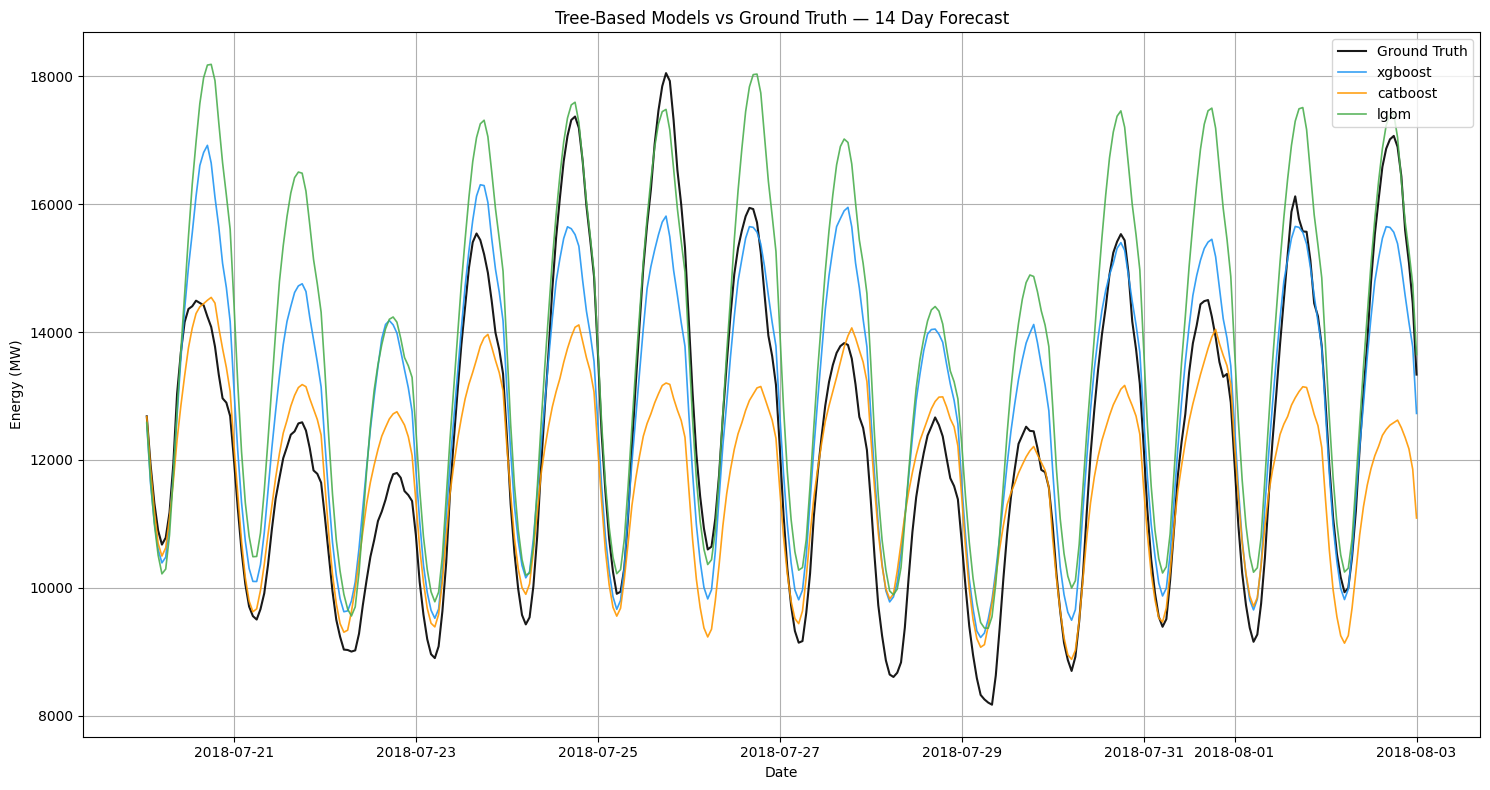

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(eval_df['ds'], eval_df['y'], label='Ground Truth', color='black', linewidth=1.5, alpha=0.9)

colors = {'xgboost': '#2196F3', 'catboost': '#FF9800', 'lgbm': '#4CAF50'}
for model, color in colors.items():
    ax.plot(eval_df['ds'], eval_df[model], label=f'{model}', color=color, linewidth=1.2, linestyle='-', alpha=0.9)

ax.set_title('Tree-Based Models vs Ground Truth — 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

#Final Forecast with LGBM\
Actual Inference 2weeks

In [ ]:
mlf_final = MLForecast(
    models={
        'lgbm': LGBMRegressor(n_estimators=500, learning_rate=0.01, verbose=0, linear_tree=True),
    },
    freq='h',
    lags=[1, 2, 24, 48, 168, 336],
    lag_transforms={
        # mlforecast will update them recursively at prediction steps
        1: [residual_24, residual_168, residual_168_24],
        24: [(rolling_mean, 24), (rolling_std, 24), (rolling_max, 24), (rolling_min, 24)],
        168: [(rolling_mean, 168), (rolling_std, 168), (rolling_max, 168), (rolling_min, 168)],
    },
)

mlf_final.fit(
    df_clean[['unique_id', 'ds', 'y'] + exogeneous_features],
    static_features=[]
)

MLForecast(models=[lgbm], freq=h, lag_features=['lag1', 'lag2', 'lag24', 'lag48', 'lag168', 'lag336', 'residual_24_lag1', 'residual_168_lag1', 'residual_168_24_lag1', 'rolling_mean_lag24_window_size24', 'rolling_std_lag24_window_size24', 'rolling_max_lag24_window_size24', 'rolling_min_lag24_window_size24', 'rolling_mean_lag168_window_size168', 'rolling_std_lag168_window_size168', 'rolling_max_lag168_window_size168', 'rolling_min_lag168_window_size168'], date_features=[], num_threads=1)

In [44]:
# build future featu

last_ds     = df_clean['ds'].max()
future_ds   = pd.date_range(start=last_ds + pd.Timedelta(hours=1), periods=336, freq='h')
future_exog = pd.DataFrame({'unique_id': 'comed_hourly', 'ds': future_ds})

future_exog['hour']       = future_exog['ds'].dt.hour
future_exog['dayofweek']  = future_exog['ds'].dt.dayofweek
future_exog['month']      = future_exog['ds'].dt.month

us_holidays_future = cal.holidays(start=future_exog['ds'].min(), end=future_exog['ds'].max())
ds_norm_future     = future_exog['ds'].dt.normalize()
future_exog['is_holiday']            = ds_norm_future.isin(us_holidays_future).astype(int)

doy = future_exog['ds'].dt.dayofyear
for k in range(1, 4):
    future_exog[f'sin_annual_{k}'] = np.sin(2 * np.pi * k * doy / 365.25)
    future_exog[f'cos_annual_{k}'] = np.cos(2 * np.pi * k * doy / 365.25)

In [45]:
future_preds = mlf_final.predict(
    h=336,
    X_df=future_exog[['unique_id', 'ds'] + exogeneous_features]
)

future_preds

,unique_id,ds,lgbm
0,comed_hourly,2018-08-03 01:00:00,12185.784034
1,comed_hourly,2018-08-03 02:00:00,11288.137485
2,comed_hourly,2018-08-03 03:00:00,10687.298147
3,comed_hourly,2018-08-03 04:00:00,10279.002258
4,comed_hourly,2018-08-03 05:00:00,10059.838578
...,...,...,...
331,comed_hourly,2018-08-16 20:00:00,16319.609264
332,comed_hourly,2018-08-16 21:00:00,15721.504581
333,comed_hourly,2018-08-16 22:00:00,15334.169382
334,comed_hourly,2018-08-16 23:00:00,14757.486031


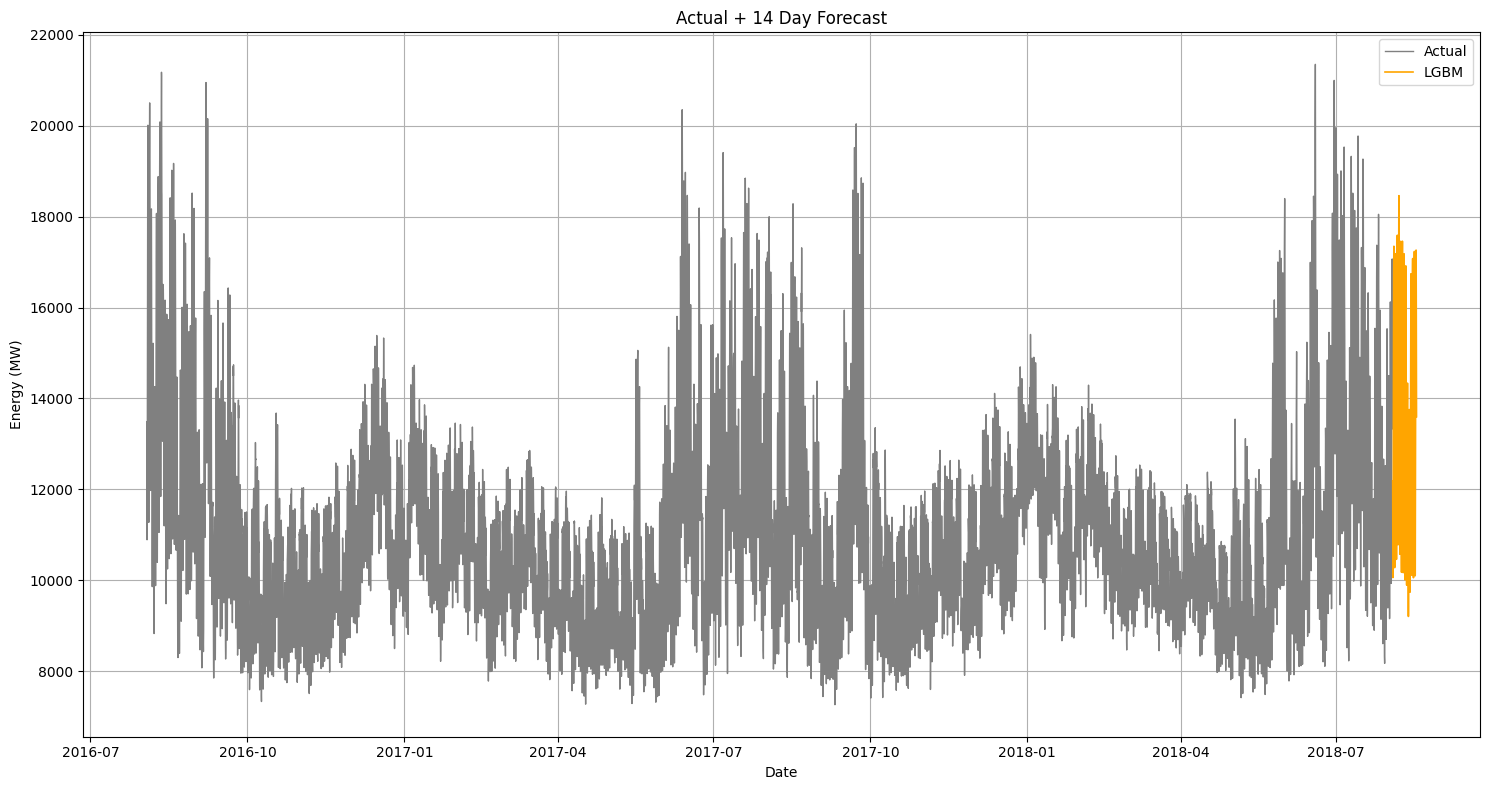

In [46]:
fig, ax = plt.subplots(figsize=(15, 8))

# last 1 year of
zoom = df_clean.iloc[-24*365*2:]

ax.plot(zoom['ds'], zoom['y'], color='gray', linewidth=1, label='Actual')
ax.plot(future_preds['ds'], future_preds['lgbm'], color='#ffA500', linewidth=1.2, linestyle='-', label='LGBM')

ax.set_title('Actual + 14 Day Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()